In [1]:
#Group Number: 27
#Group Members: Luca Macesanu, Samik Singh, Carson Ngyuen, Mathew Huang

# Problem Statement

For our project, we wanted to create a model to play a videogame. During the process, we first considered playing pokemon. However, we were unable to find a robust dataset to use. Therefore, we ended up moving forward with the gym retro library where we were able to load games and create our own dataset. The game we wanted to choose was Mortal Kombat. However, that didn't work as we were unable to get it to run. Therefore, we settled on Super Mario Bros. Therefore, we decided to create models that would be able to complete world 1-1 of Super Mario Bros.


We first collected data. Then we moved on to using classification based approaches similar to what we learned in class. Lastly, we used Proximal Policy Optimization to expand upon our knowledge. 


# Data Collection


Since there were no existing datasets for our project, we decided to collect our own data. We collected a total of 128942 state action pairs in order to treat gameplay as a classification problem in order to predict how a human would play the game. 


Since we collected the data, data cleaning was more minimal. We remapped our action spaces as there were many action outputs that matched the state of the game. By consolidating these actions, we reduced the overall spread of our data. We also scaled the state space by normalizing pixel values making it easier to process as well. Lastly, we manually combed through the files removing corrupted or improperly recorded data.

### Refer to collect_data.py to test out data collection script


In [2]:
#imports
import matplotlib.pyplot as plt
import numpy as np

# Custom imports
from playback import get_state_action_pairs

In [3]:
def eliminate_unnecessary_action(data):
    action_space = data
    
    #This might not be necessary but im on a time crunch (Theres 100% a better way to do this)
    action_map = {
        64: 0,
        65: 1,
        66: 2,
        67: 3,
        128: 4,
        129: 5,
        130: 6,
        131: 7
    }
    
    # Map original action values to new values
    action_space = np.array([action_map.get(action, 0) for action in action_space])
    #print(action_space.size())
    
    return action_space

We generated graphs to display the frequency and the average state of a subset of our data. 

Adding  imitation_mario_rec_carson_032124_142721.npz
Adding  imitation_mario_rec_carson_032124_143046.npz
Adding  imitation_mario_rec_carson_032124_143622.npz


Text(0.5, 1.0, 'Action Frequency Chart')

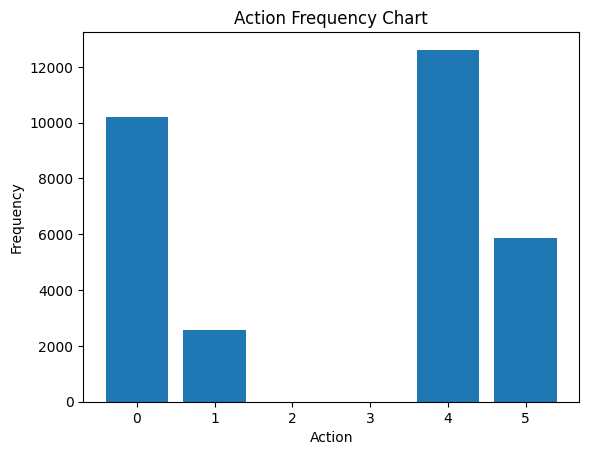

In [4]:
# generate bar chart of action frequencies
rec_state_history, rec_action_history = get_state_action_pairs(3)
#load data
rec_action_history = eliminate_unnecessary_action(rec_action_history)

unique_vals, frequencies = np. unique(rec_action_history, return_counts = True)
plt.bar(unique_vals, frequencies)
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.title('Action Frequency Chart')

In [5]:
def average_images(images):
    average_image = np.mean(images, axis=0)
    plt.imshow(average_image, cmap = 'gray')
    plt. title('Average Image')
    plt.axis('off')
    plt.show()

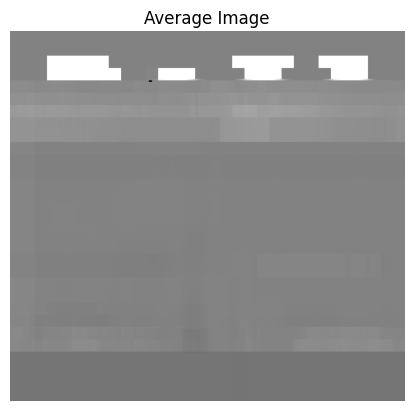

In [6]:
#np mean of states
average_images(rec_state_history)

# Classification Based Approaches

## 1. KNN

We used KNN as an example as to why our agent should not use classification methods using state-action pairs to solve the issue. One issue is KNN's susceptibility to noise. Since there are so many permutations to how a scene could be set depending on where the enemies are relative to the scene, it is hard for us to fully clean our data of noises as it is a large part of the game. 

Another issue for KNN is the curse of dimensionality. This dataset is composed of two numpy arrays: a 3D array that describes the environment and a 1D array that describes the action taken. In many cases in training, our players did drastically different actions at the same observation or the same action at a slightly different observation. Therefore, KNN has difficulties in finding similarities between records. This resulted in our KNN model taking vast amounts of time for training off of a singular isolated run and thus not finishing. We included the code as a large comment since it wil be unable to run in a realistic timeframe due to the sheer size of our data, even when drastically reducing the amount of data used. 

In [7]:
'''
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import pickle
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from gym.wrappers import GrayScaleObservation
import os
import sklearn as sk
from sklearn.pipeline import Pipeline

# Custom imports assuming these are correctly implemented
from playback import get_state_action_pairs

class knn:
    def __init__(self, model = None, n_n= 10):
        self.done = False
        self.name = "KNN"

        #generates a pipeline that scales and decreases dimensions. 
        if model is None:
            pline = Pipeline([('scaler', sk.preprocessing.StandardScaler()), ('pca', sk.decomposition.PCA()), 
                  ('knn', KNeighborsClassifier(n_neighbors= n_n))])
            self.model = pline
        else:
            self.model = model

    def get_action(self, state):
        state = state.flatten().reshape(1, -1)
        return self.model.predict(state)

    def train(self, state_history, action_history):
        self.model.fit(state_history, action_history)
        pickle.dump(self.model, open("knn.p", "wb"))
        print("Training Complete.")

    def evaluate_and_tune(self, features, labels):
        parameters = {
             'n_neighbors': [None, 5, 10, 15]
        }
        cv = 5
        grid_search = GridSearchCV(self.model, parameters, cv=cv, scoring='accuracy', return_train_score=True)
        grid_search.fit(features, labels)

        print('Best Parameters:', grid_search.best_params_)
        return grid_search

def plot_accuracy(grid_search):
    results = grid_search.cv_results_
    plt.figure(figsize=(10, 5))
    plt.title("Training vs Validation Accuracy")
    plt.plot(results['mean_train_score'], label='Train Accuracy')
    plt.plot(results['mean_test_score'], label='Validation Accuracy')
    plt.xlabel('Parameter Combination')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def run_agent(agent):
    env = GrayScaleObservation(gym.make("SuperMarioBros-v3"))
    env.reset()
    done = False
    state_history = []
    action_history = []

    with tqdm(total=100) as pbar:
        while not done:
            state, reward, done, _ = env.step(0)  # Example using a constant action
            action = agent.get_action(state)
            state_history.append(state)
            action_history.append(action)
            pbar.update(1)

    env.close()



if __name__ == "__main__":
    record_path = "recordings"
    
    if not os.path.isdir(record_path):
        print(f"Error: {record_path} is not a valid directory.")
    else:
        rec_state_history, rec_action_history = get_state_action_pairs(2)

        if rec_state_history.ndim == 3:
            nsamples, height, width = rec_state_history.shape
            rec_state_history = rec_state_history.reshape((nsamples, height * width))

        print("Reshaped state history shape:", rec_state_history.shape)

        train_states, test_states, train_actions, test_actions = train_test_split(
            rec_state_history, rec_action_history, test_size=0.2, random_state=42)

        agent = knn()
        agent.train(train_states, train_actions)

        grid_search = agent.evaluate_and_tune(train_states, train_actions)
        plot_accuracy(grid_search)

        run_agent(agent)

'''

'\nimport gym\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score\nimport pickle\nfrom datetime import datetime\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom tqdm import tqdm\nfrom gym.wrappers import GrayScaleObservation\nimport os\nimport sklearn as sk\nfrom sklearn.pipeline import Pipeline\n\n# Custom imports assuming these are correctly implemented\nfrom playback import get_state_action_pairs\n\nclass knn:\n    def __init__(self, model = None, n_n= 10):\n        self.done = False\n        self.name = "KNN"\n\n        #generates a pipeline that scales and decreases dimensions. \n        if model is None:\n            pline = Pipeline([(\'scaler\', sk.preprocessing.StandardScaler()), (\'pca\', sk.decomposition.PCA()), \n                  (\'knn\', KNeighborsClassifier(n_neighbors= n_n))])\n            self.model = pline\n        else:\n            self.model = model\n\n    def get_action

# 2. Decision Trees
We then decided to approach Decision Trees as another method to classify our state-action pairs.

This could be potentially fitting as Mario although could be approached creatively could also have a robotic optimal route. We also debated about the potential downsides to a Decision Tree. We believed that our data is filled with many occurrences of the same observation but slightly different actions in reaction to the same environment. 

In one run, the same person could jump at a frame earlier and thus not jump at the consequent frame or the same person could jump
at the consequent frame and not do anything in the frame prior. This makes it difficult for the agent to draw similarities
between runs, making it hard for the tree to fit an action to a specific state.

In [8]:
#imports for decision trees
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import pickle
from datetime import datetime
from tqdm import tqdm
from gym.wrappers import GrayScaleObservation
import os
from sklearn import tree
# Custom imports
from playback import get_state_action_pairs

Here we created the code for the Decision Tree Class. We tested 2 parameters with 3 and 4 values respectively. We tested Gini, Entropy, and Log Loss for Criterion, and we tested None, 10, 20, and 30 for max depth.

In [9]:
# Decision Tree Class
class DecisionTree:
    def __init__(self, model = None, max_d = 10, dummy = False):
        self.done = False
        self.name = "decision_tree"
        if model is None:
            self.model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_d)
        else:
            self.model = model

    def get_action(self, state):
        state = state.flatten().reshape(1, -1)
        return self.model.predict(state)

    def train(self, state_history, action_history):
        self.model.fit(state_history, action_history)
        pickle.dump(self.model, open("decision_tree_model.p", "wb"))
        print("Training Complete.")

    def evaluate_and_tune(self, features, labels):
        parameters = {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [None, 10, 20, 30]
        }
        cv = 5
        grid_search = GridSearchCV(self.model, parameters, cv=cv, scoring='accuracy', return_train_score=True)
        grid_search.fit(features, labels)

        print('Best Parameters:', grid_search.best_params_)
        return grid_search


In [10]:
def run_agent(agent):
    env = GrayScaleObservation(gym.make("SuperMarioBros-v3"))
    env.reset()
    done = False
    state_history = []
    action_history = []

    with tqdm(total=100) as pbar:
        while not done:
            state, reward, done, _ = env.step(0)  # Example using a constant action
            action = agent.get_action(state)
            state_history.append(state)
            action_history.append(action)
            pbar.update(1)

    env.close()

In [11]:
record_path = "recordings"

if not os.path.isdir(record_path):
    print(f"Error: {record_path} is not a valid directory.")
else:
    rec_state_history, rec_action_history = get_state_action_pairs(2)

    if rec_state_history.ndim == 3:
        nsamples, height, width = rec_state_history.shape
        rec_state_history = rec_state_history.reshape((nsamples, height * width))

    print("Reshaped state history shape:", rec_state_history.shape)

    train_states, test_states, train_actions, test_actions = train_test_split(
        rec_state_history, rec_action_history, test_size=0.2, random_state=42)

    agent = DecisionTree()
    agent.train(train_states, train_actions)

    grid_search = agent.evaluate_and_tune(train_states, train_actions)


Adding  imitation_mario_rec_carson_032124_142721.npz
Adding  imitation_mario_rec_carson_032124_143046.npz
Reshaped state history shape: (13199, 61440)


KeyboardInterrupt: 

In [ ]:
run_agent(agent)

We then visualized our results by comparing the various hyperparameters in their training and validation accuracies. From our results, we noticed that set 1 and 5 had similar training and validation accuracies of roughly 1 and 0.8 respectively. Scikit learn approaches accuracy by using existing data rather than testing it in the Mario Environment in the Gym library. This means that the Decision Tree was good at predicting what a human operator would do. Therefore, this would work great if the data was made by a world class Mario Speedrunner. However, since it isn't and we are not very good at Mario, the decision Tree will not perform at high levels and outperform us by far if at all. 


Combinations (criterion, max depth):

Set 1: Gini + none      

Set 2: Gini + 10      

Set 3: Gini + 20 

Set 4: Gini+ 30 

Set 5: Entropy + none 

Set 6: Entropy + 10 

Set 7: Entropy + 20 

Set 8: Entropy + 30 

Set 9: Log loss + none 

Set 10: Log loss + 10 

Set 11: Log loss + 20 

Set 12: Log loss + 30 


In [ ]:
results = grid_search.cv_results_
sets = ['set 1', 'set 2', 'set 3', 'set 4', 'set 5' , 'set 6', 'set 7', 'set 8', 'set 9', 'set 10', 'set 11', 'set 12']
plt.figure(figsize=(10, 5))
plt.title("Training Accuracy")
plt.bar(sets, results['mean_train_score'], width= 0.5)
plt.xlabel('Parameter Combination')
plt.ylabel('Accuracy')

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Validation Accuracy")
plt.bar(sets, results['mean_test_score'], width= 0.5)
plt.xlabel('Parameter Combination')
plt.ylabel('Accuracy')

# 3. ADABoosting
ADABoosting Description: The next algorithm we utilized to classify our state-action pairs is ADABoosting with decision tree stumps as the base classifier.
Though the accuracy of the boosting model is generally higher than techniques alone, for our purposes we should take into account that we are using a supervised learning base model (decision tree stumps). Since the goal of our classification is to classify in a way that allows the model to beat the super mario game, the application of ensembling might not be the best as it would base the action it takes strictly on the states ran through by a mario play-through done by the user, which could be susceptible to faulty playthroughs. If we were to apply an RL agent on the other hand which creates policies on the premise of maximizing rewards as our model for ADABoosting, it would likely be a good approach as the accuracy would be increased substantially.

In [ ]:
#imports
import gym
from nes_py.wrappers import JoypadSpace
from nes_py.app.play_human import play_human
from gym.wrappers.gray_scale_observation import GrayScaleObservation
import cv2
import numpy as np
from datetime import datetime
from sklearn.ensemble import *
import pickle
from playback import get_state_action_pairs
from sklearn.model_selection import *

Here we created the code for the Boosting Agent Class. We tested 2 Parameters with 3 different values total. We tested 40, 50, and 60 estimators, and we tested learning rates of 0.8, 1.0, and 1.2. 

In [ ]:
# ADABoost
class boosting_agent:
    def __init__(self, model = None, n_estimators = 50):
        self.done = False
        self.name = "boosting_agent"
        if model is None:
            self.model = AdaBoostClassifier(n_estimators = n_estimators)
        else:
            self.model = model

    def get_action(self, state):
        state = state.flatten().reshape(1, -1)
        return self.model.predict(state)

    def train(self, state_history, action_history):
        self.model.fit(state_history, action_history)
        pickle.dump(self.model, open("models/booster_model.p", "wb"))
        print("Training Complete.")

    def evaluate_and_tune(self, features, labels):
        parameters = {
            'n_estimators': [40, 50, 60],
            'learning_rate': [0.8, 1.0, 1.2]
        }
        cv = 5
        grid_search = GridSearchCV(self.model, parameters, cv=cv, scoring='accuracy', return_train_score=True)
        grid_search.fit(features, labels)

        print('Best Parameters:', grid_search.best_params_)
        return grid_search


We begin our run_agent by converting our observations to grayscale then resetting the environment. We then intialize our state_history and action_history and record the said states and actions. We then retrieve actions based on current states.

In [ ]:
def run_agent(agent):
    env = GrayScaleObservation(gym.make("SuperMarioBros-v3"))
    env.reset()
    done = False
    state_history = []
    action_history = []

    with tqdm(total=100) as pbar:
        while not done:
            state, reward, done, _ = env.step(0)  # Example using a constant action
            action = agent.get_action(state)
            state_history.append(state)
            action_history.append(action)
            pbar.update(1)

    env.close()

The code below first check wether the record_path exists. It then retrieves the state-action pairs from the recorded data. As specified by the line get_state_action_pairs(2), if our state_history has a three-dimensional shape we then reshape it two-dimensions for compatibility. Finally we allocate 20% of our data as our testing set sie. We then perform evaluation and tuning using grid search.

In [ ]:
record_path = "recordings"

if not os.path.isdir(record_path):
    print(f"Error: {record_path} is not a valid directory.")
else:
    rec_state_history, rec_action_history = get_state_action_pairs(2)

    if rec_state_history.ndim == 3:
        nsamples, height, width = rec_state_history.shape
        rec_state_history = rec_state_history.reshape((nsamples, height * width))

    print("Reshaped state history shape:", rec_state_history.shape)

    train_states, test_states, train_actions, test_actions = train_test_split(
        rec_state_history, rec_action_history, test_size=0.2, random_state=42)

    agent = boosting_agent()
    agent.train(train_states, train_actions)

    grid_search = agent.evaluate_and_tune(train_states, train_actions)


In [ ]:
run_agent(agent)

We then visualized our results by comparing the various hyperparameters in their training and validation accuracies. One noticable trend is the overall low training and validation accuracies are all generally low, being close to 0.3 with the highest being from Set 4. This means that it is fitting poorly to the human data. This could potentially mean that it is improving and thus deviating from it. However, more likely than not, this is showing that ADABoosting using a supervised learning base model will perform equal to if not worse than a human operator in Mario.  

combinations (n estimators, learning rate):

Set 1: (40, 0.8) 

Set 2: (40, 1.0) 

Set 3: (40, 1.2) 

Set 4: (50, 0.8) 

Set 5 (50, 1.0) 

Set 6 (50, 1.2) 

Set 7 (60, 0.8) 

Set 8(60, 1.0) 

Set 9 (60, 1.2)

In [ ]:
results = grid_search.cv_results_
sets = ['set 1', 'set 2', 'set 3', 'set 4', 'set 5' , 'set 6', 'set 7', 'set 8', 'set 9']
plt.figure(figsize=(10, 5))
plt.title("Training Accuracy")
plt.bar(sets, results['mean_train_score'], width= 0.5)
plt.xlabel('Parameter Combination')
plt.ylabel('Accuracy')

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Validation Accuracy")
plt.bar(sets, results['mean_test_score'], width= 0.5)
plt.xlabel('Parameter Combination')
plt.ylabel('Accuracy')

In [ ]:
#save boosting agent
pickle.dump(agent, open("/models/BoostingAgent.p", "wb"))

# 4. CNN

Process: Our process involved splitting the dataset into training and validation sets using a 80-20 ratio. We tested every combination of kernel size and activation function for 4 epochs. Once we decided not to vary our batch size we kept it constant at 32. We then recorded the training histories which included the training and validation accuracies for each combination of hyperparameters.

Conclusion: Based on hyperparameter tuning we found that the combination of a kernel size with (7,7) and the sigmoid activation function seemed to be the most effective as evidenced by the training and validation accuracy.

Further steps: In order to further tune our hyperparameters to make more accurate predictions we could vary the number of our convolutional layers. Since increasing the number of convolutional layers may allow our model to distinguish between more complex representations, we may be able to improve our performance. We could also test different learning rates to optimize convergence.




In [13]:
import gym_super_mario_bros
import gym
import nes_py
from nes_py.wrappers import JoypadSpace
from nes_py.app.play_human import play_human
from gym.wrappers.gray_scale_observation import GrayScaleObservation
import cv2
import numpy as np
import sys
from datetime import datetime
import argparse
import pickle
from playback import get_state_action_pairs 
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

ModuleNotFoundError: No module named 'tensorflow'

The below code converts our game space from rgb to grayscale. Eliminate unecessary action remaps our actionspace from 0->7 as this is what our action input data is looking for. Each number responds to a specific action such as 128 occurs when the user click d and it causes Mario to move forward.

In [ ]:

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def eliminate_unnecessary_action(data):
    action_space = data
    action_map = {
        64: 0,
        65: 1,
        66: 2,
        67: 3,
        128: 4,
        129: 5,
        130: 6,
        131: 7
    }
    
    action_space = np.array([action_map.get(action, 0) for action in action_space])
    return action_space

The code below defines a specific CNN architecture. It is using TensorFlow's keras library.

In [ ]:
# Create CNN model with specific layers, some values given from CNN tutorial with tensorflow
def create_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

Kernel Sizes: We tested three different kernel sizes ((3,3),(5,5),(7,7)). As a smaller kernel sizes focus on smaller regions of our input image, we expected the larger kernel sizes to be more effective as they would capture a wider range of information from our input image.

Activation Functions: We tested three different activation functions (Rectified Linear Unit, Hyperbolic Tangent, and Sigmoid).
As relu (Rectified Linear Unit), is known for its effectiveness with regards to deep learning models, we expected it to perform the best.

Note: Tried batch sizes but didn't feel it had a significant enough change in our accuracy. Now we set our batch size to 32.

The code below also graphs both the training accuracy and the validation accuracy over a specified amount of epochs. The graph line colors correspond to the specific combination of kernel sizes and and activation functions. The same combination color is used for the training accuracy and the validation accuracy.

In [ ]:
def hyperparameter_tuning(state_history, action_history):
    kernel_sizes = [(3, 3), (5, 5),(7,7)]
    activation_functions = ['relu','tanh','sigmoid']
    #batch_sizes = [32, 64, 128]

    training_histories = []
    accuracies = []

    for kernel_size in kernel_sizes:
        for activation_function in activation_functions:
            print(f"training with kernel size: {kernel_size} and activation function: {activation_function}")
            train_a, test_a, train_b, test_b = train_test_split(state_history, action_history, test_size=0.2, random_state=42)
            train_a = np.expand_dims(train_a, axis=-1)
            test_a = np.expand_dims(test_a, axis=-1)
            
            train_a = train_a / 255.0
            test_a = test_a / 255.0

            model = create_cnn(input_shape=(state_history.shape[1], state_history.shape[2], 1), num_classes=np.max(action_history) + 1)
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            history = model.fit(train_a, train_b, epochs=20, batch_size=32, validation_data=(test_a, test_b))

            training_histories.append(history)
            accuracies.append(history.history['val_accuracy'][-1])
            plt.figure(figsize=(10, 12))
    colors = plt.cm.tab10.colors[:len(kernel_sizes) * len(activation_functions)]

    plt.subplot(2, 1, 1)
    for i, kernel_size in enumerate(kernel_sizes):
        for j, activation_function in enumerate(activation_functions):
            plt.plot(range(1, 21), training_histories[i*len(activation_functions)+j].history['accuracy'], label=f'kernel size:{kernel_size}, activation:{activation_function}')

    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Training Accuracy')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=3,fontsize='small')

    plt.subplot(2, 1, 2)
    for i, kernel_size in enumerate(kernel_sizes):
        for j, activation_function in enumerate(activation_functions):
            color = colors[i*len(activation_functions)+j]
            plt.plot(range(1, 21), training_histories[i*len(activation_functions)+j].history['val_accuracy'], label=f'kernel size: {kernel_size}, activation:{activation_function}', color=color)

    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('validation accuracy')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fontsize='small')

    plt.tight_layout()
    plt.show()

    print("Validation Accuracies:")
    for i, kernel_size in enumerate(kernel_sizes):
        for j, activation_function in enumerate(activation_functions):
            print(f'kernel size:{kernel_size}, activation:{activation_function}: {accuracies[i*len(activation_functions)+j]}')

Define the CNN Agent.

In [ ]:
class CNNAgent:
    def __init__(self, model=None, state_history=None, action_history=None):
        self.done = False
        self.name = "cnn_agent"
        if model is None:
            num_classes = np.max(action_history) + 1
            self.model = create_cnn(input_shape=(state_history.shape[1], state_history.shape[2], 1), num_classes=num_classes)
        else:
            self.model = model

    def get_action(self, state):
        state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=-1)
        return np.argmax(self.model.predict(state))
        
    def train(self, state_history, action_history):

        print("Training...")
        train_a, test_a, train_b, test_b = train_test_split(state_history, action_history, test_size=0.2, random_state=42)
        train_a = np.expand_dims(train_a, axis=-1)
        test_a = np.expand_dims(test_a, axis=-1)
        train_a = train_a / 255.0
        test_a = test_a / 255.0
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = self.model.fit(train_a, train_b, epochs=1, validation_data=(test_a, test_b))
        self.model.save("models/cnn_model.h5")
        print("Training complete.")

        #Graph validation and training accuracy as epochs increase
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()
        pass


Run the CNN Agent and extract the required reward_history, action_history, and state_history from the data

In [ ]:
def run_agent(agent):

    env = GrayScaleObservation(gym_super_mario_bros.make("SuperMarioBros-v3"))
    env.reset()

    action_history = []
    state_history = []
    reward_history = []

    action = [0]
    done = False
    while not done:
        state, reward, done, _ = env.step(action)
        action_history.append(action)
        state_history.append(rgb2gray(state))
        reward_history.append(reward)
        action = agent.get_action(state)
        if done:
            print("Done")
            break
        if agent.done:
            print("Agent done")
            done = True
            break

    day_time = datetime.today().strftime("%m%d%y_%H%M%S")
    np.savez(f".\\agent_recordings\\{agent.name}_{day_time}", np.array(state_history), np.array(action_history), np.array(reward_history))
    print("Recording saved")
    env.close()
    cv2.destroyAllWindows()
    print("Windows closed")


In [ ]:

rec_state_history, rec_action_history = get_state_action_pairs(2)
rec_action_history = eliminate_unnecessary_action(rec_action_history)
agent = CNNAgent(model=None, state_history=rec_state_history, action_history=rec_action_history)
hyperparameter_tuning(rec_state_history, rec_action_history)

# 4. Proximal Policy Optimization using Stable Baselines 3
After finding that most classification approaches failed to yield useful results, we decided to consult the literature for a more appropriate approach. Promimal Policy Optimization (https://arxiv.org/pdf/1707.06347.pdf) is a reinforcement learning approach developed by OpenAI in 2017. Since then it has become a standard approach for reinforcement learning tasks. After doing some research online, we were able to find a utility wrapper for the SuperMarioBros gym environment. This wrapper accesses the RAM of the NES simulator directly, exposing the location of Mario and the scene features directly. This makes it easier for PPO to learn a performant policy more quickly as it doesn't need to learn the mapping from the image space to semanticly meaningful features.



In [ ]:
# All necessary imports
from nes_py.wrappers import JoypadSpace
import gym 
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY 

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
import os
import time
import matplotlib.pyplot as plt
from datetime import datetime
from gym_utils import SMBRamWrapper
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

%matplotlib inline

### Defining Callback and Helper Functions
The logging callback class is used to populate the score/time_step lists for later display.  
The linear schedule is derived from the stablebaselines documentation, and is considered a standard approach for PPO.

In [ ]:
from typing import Callable
class SaveCallback(BaseCallback):

    def __init__(self, check_freq, env_wrap, starting_steps=0, verbose=1):
        super(SaveCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.starting_steps = starting_steps
        self.model_directory = "./"

    def _init_callback(self):
        self.env_wrap = self.model.get_env()
        print("Initialized Callback")
        if not os.path.exists(self.model_directory):
            os.mkdir(self.model_directory)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            self.model.save(self.model_directory + "model_" + str(self.n_calls))
        return True
    
# Linear learning rate schedule
# https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#learning-rate-schedule
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

### Creating the environment
The environment we are using is the classic super mario bros. There is a RAM access wrapper to reduce the state space for easier policy learning, we well as monitor/dummy vec which enable callback functionality that we are using to save off versions of the model and track performance.

In [ ]:
# Create the environment, this needs to be re-run if you call env.close()
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v3')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
x0 = 0
x1 = 16
y0 = 0
y1 = 13
n_stack = 4
n_skip = 4
env_wrap = SMBRamWrapper(env, [x0, x1, y0, y1], n_stack=n_stack, n_skip=n_skip)
env_wrap = Monitor(env_wrap)
env_wrap = DummyVecEnv([lambda: env_wrap])



In [ ]:
# Training models on different hyperparameters
batch_sizes = [16,32,64]
n_epochs = [8,10,12]
gammas = [0.8,0.9,0.99]

models = []
evals = []
for batch_size in batch_sizes:
    for n_epoch in n_epochs:
        for gamma in gammas:
            model = PPO('MlpPolicy', env_wrap, verbose=0, learning_rate=linear_schedule(3e-4), batch_size=batch_size,n_epochs=n_epoch,gamma=gamma) 
            model.learn(total_timesteps=1e3)
            eval = evaluate_policy(model, env_wrap, n_eval_episodes=1, deterministic=True, render=False, return_episode_rewards=False)
            models.append(model)
            evals.append(eval)

### Results of hyperparameter selection
As is evident, the groups are largely split into >200 or <350 in terms of average reward per life. Inspection of the replays indicates that this is due to either dying to the first enemy, or jumping over and moving forward. We will select the model with the highest performance and move on to more rigorous training.

In [ ]:
# Average rewards of all the trained models
plt.figure()
evals = np.array(evals)
evals = evals[:,0]
plt.bar([i for i in range(len(evals))],evals)
plt.show()

In [ ]:
# Get the combination of the best hyperparameters
best_model_index = np.argmax(evals)
best_model = models[best_model_index]
best_batch_size = best_model.batch_size
best_num_epochs = best_model.n_epochs
best_gamma = best_model.gamma
print("Best performance: ", max(evals))
print("Best Batch Size: ",best_batch_size)
print("Best Number of Epochs: ",best_num_epochs)
print("Best Gamma: ", best_gamma)

From the last line we have determined that the optimal batch_size is 16, n_epochs is 12, and gamma is 0.8

In [ ]:
# Create an optimal model and train it for a significant amount of time
best_batch_size = 16
best_num_epochs = 12
best_gamma = 0.8


del model
model = PPO('MlpPolicy', env_wrap, verbose=0, learning_rate=linear_schedule(3e-4), batch_size=best_batch_size,n_epochs=best_num_epochs,gamma=best_gamma) 
callback = SaveCallback(check_freq=1e4, starting_steps=0, env_wrap = env_wrap)
model.learn(total_timesteps=1e3, callback = callback)
eval = evaluate_policy(model, env_wrap, n_eval_episodes=1, deterministic=True, render=False, return_episode_rewards=False)
print("Performance: ", eval)
model.save("best_model1e3")

### Seeing our best performance
Here we will run a simulation using the PPO agent to see what it has learned. A disclaimer, once the simulation is run the environemnt will close, necessitating a new one to be loaded if further notebook use is desired.

In [ ]:
if model:
    del model
model = PPO('MlpPolicy', env_wrap, verbose=0, learning_rate=linear_schedule(3e-4), batch_size=best_batch_size,n_epochs=best_num_epochs,gamma=best_gamma) 
model.load("best_model1e6")
states = env_wrap.reset()
done = False
score = 0
max_steps = 1e4
while not done and max_steps > 0:
    max_steps -=1
    env_wrap.render()
    action, _ = mod.predict(states, deterministic=True)
    states, reward, done, info = env_wrap.step(action)
    score += reward
    time.sleep(0.01)
print('Score: ', score)

In [ ]:
env.close()

### Conclusion
All in all our experience demonstrates the difficulties of learning to play a game using classical machine learning approaches. We also demonstrate the power of new Reinforcement Learning approaches in exporing the state space and finding a performant policy. We also attemped oher approaches such as Behavioral Cloning, Adversarial Inverse Reinforcement Learning, and Generative Adversarial Imitation Learning, however the stable baselines implementations were not compatible with the gym verisons we are using. Further work should include integrating these other state of the art approaches into our work.